<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-DCGAN-128x128">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    DCGAN 128x128
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Генератор">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Генератор
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Дискриминатор">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Дискриминатор
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Обучение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
            </ul>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративно-состязательная сеть | DCGAN 128x128

**Постановка задачи:** натренировать генеративную модель - автоэнкодер или генеративно-состязательную сеть для генерации изображений животных.

**Источник данных:** датасет [petfaces.tar.gz](http://www.soshnikov.com/permanent/data/petfaces.tar.gz) или [Oxford-IIIT](https://www.robots.ox.ac.uk/~vgg/data/pets/).

**Характер данных:** 

* *petfaces:* 35 пород домашних животных (12 пород кошек и 23 породы собак), по 200 изображений на каждый класс (изображение центрированы и уменьшены до небольшого размера) 
* *Oxford-IIIT:* 37 категорий животных по 200 изображений на каждый класс

**Основные этапы:** 

1. Начать экспериментировать с изображениями небольшого размера - 64x64 пикселя.
2. Затем посмотреть, получится ли увеличить размер до 128x128 или 256x256.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

# Реализации:

1. [Базовая линейная модель](https://github.com/MAILabs-Edu-2023/magai_lab2_cnn-lab_ai/blob/main/GAN.ipynb)
2. [DCGAN 64x64](https://github.com/MAILabs-Edu-2023/magai_lab2_cnn-lab_ai/blob/main/GAN_64x64.ipynb)
3. DCGAN 128x128 (текущий файл)

**Обоснование разделения файлов:** в ходе множественных испытаний было замечено, что при последовательном обучении нескольких по-разному реализованных генеративно-состязательных сетей результаты каким-то образом воздействовали друг на друга, из-за чего генерация изображений происходила некорректно.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка необходимых библиотек:

In [1]:
%%capture --no-display
import torch
if torch.__version__ != '1.13.1+cu117':
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [2]:
%%capture --no-display
!pip install wget torchinfo

Импорт библиотек:

In [1]:
import numpy as np

from tqdm.notebook import tqdm
from functools import reduce
from typing import Tuple

import random
import os
import kaggle
import zipfile as zf

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from utils.plot_charts import plot_random_image, plot_transformed_images, \
                              plot_loss, save_image, create_gif, plot_comparison_real_fake

Задание случайных величин:

In [4]:
SEED = 999

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

Выведение на экран текущего устройства:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Current device:', device)

Current device: cuda


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Добавление папки `data`:

In [6]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

Задание пути до папки с набором данных:

In [7]:
path_data = 'data/oxford_pets'

Скачивание набора данных:

In [8]:
if os.path.isdir(path_data) == False:
    os.chdir('data/')
    
    !kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset
    
    with zf.ZipFile('data/the-oxfordiiit-pet-dataset.zip', 'r') as file:
        file.extractall('.')
    
    os.rename('images', 'oxford_pets')
    os.remove('the-oxfordiiit-pet-dataset.zip')
    
    os.chdir('..')

Выведение на экран изображения и его параметров:

Путь к изображению: data\oxford_pets\images\wheaten_terrier_179.jpg
Класс изображения: images
Высота: 330 | Ширина: 500
Размерность изображения (330, 500, 3) -> [height, width, color_channels]


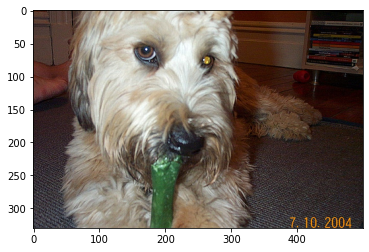

In [9]:
plot_random_image(path_data, depth='*/*')

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 DCGAN 128x128

Структура слоёв нейросети DCGAN (Deep Convolutional GAN (Generative Adversarial Network)):

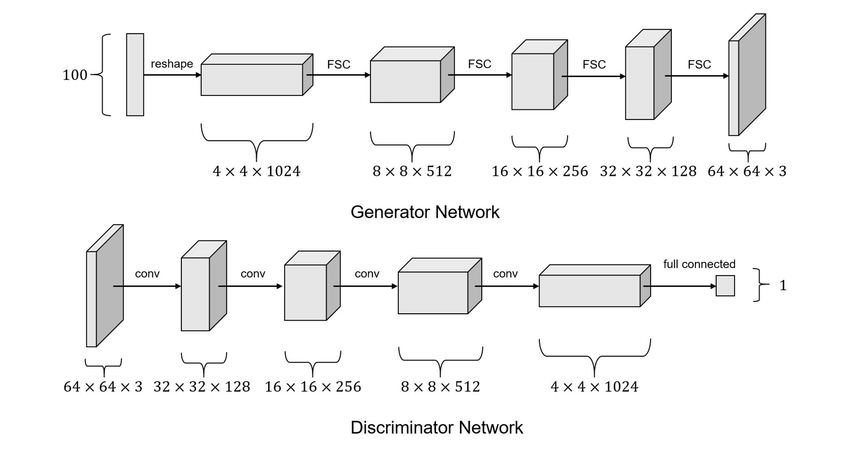

Задание функции инициализации весов:

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

---

Задание констант:

In [11]:
SIZE = 128
BATCH_SIZE = 16
N_WORKERS = os.cpu_count()
SAMPLE_SIZE = 100

Задание трансформатора изображений:

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize((SIZE, SIZE)), 
    transforms.ToTensor(),
])

Выведение на экран исходного и трансформированного изображений:

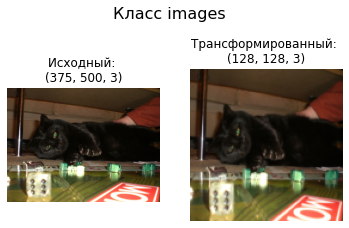

In [13]:
plot_transformed_images(data_transforms, 1, path_data, depth='*/*')

Формирование тренировочного датасета:

In [14]:
train_data = datasets.ImageFolder(
    root=path_data, 
    transform=data_transforms
)

Выведение на экран описания тренировочного датасета:

In [15]:
train_data

Dataset ImageFolder
    Number of datapoints: 7389
    Root location: data/oxford_pets
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Преобразование датасета в загрузчик данных:

In [16]:
train_dataloader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    num_workers=N_WORKERS,
    shuffle=True, 
    drop_last=True
)

---

### 3.1 Генератор

Задание класса генератора:

In [17]:
class Generator_128(nn.Module):
    def __init__(self, sample_size: int) -> None:
        super(Generator_128, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(sample_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )
        
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        
        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.conv6 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = self.conv1(z)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        return x

Объявление класса генератора:

In [18]:
generator = Generator_128(SAMPLE_SIZE).apply(weights_init).to(device)

Выведение на экран слоёв генератора:

In [19]:
generator

Generator_128(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv5): Sequential(
   

Выведение на экран подробного описания процесса изменения тензоров по ходу работы модели и информации о модели:

In [20]:
summary(generator)

Layer (type:depth-idx)                   Param #
Generator_128                            --
├─Sequential: 1-1                        --
│    └─ConvTranspose2d: 2-1              1,638,400
│    └─BatchNorm2d: 2-2                  2,048
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-4              8,388,608
│    └─BatchNorm2d: 2-5                  1,024
│    └─ReLU: 2-6                         --
├─Sequential: 1-3                        --
│    └─ConvTranspose2d: 2-7              2,097,152
│    └─BatchNorm2d: 2-8                  512
│    └─ReLU: 2-9                         --
├─Sequential: 1-4                        --
│    └─ConvTranspose2d: 2-10             524,288
│    └─BatchNorm2d: 2-11                 256
│    └─ReLU: 2-12                        --
├─Sequential: 1-5                        --
│    └─ConvTranspose2d: 2-13             131,072
│    └─BatchNorm2d: 2-14                 128
│    └─ReLU: 2-15              

---

### 3.2 Дискриминатор

Задание класса дискриминатора:

In [21]:
class Discriminator_128(nn.Module):
    def __init__(self) -> None:
        super(Discriminator_128, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv2 = nn.Sequential(            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = self.conv1(z)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        return x

Объявление класса дискриминатора:

In [22]:
discriminator = Discriminator_128().apply(weights_init).to(device)

Выведение на экран слоёв дискриминатора:

In [23]:
discriminator

Discriminator_128(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256

Выведение на экран подробного описания процесса изменения тензоров по ходу работы модели и информации о модели:

In [24]:
summary(discriminator)

Layer (type:depth-idx)                   Param #
Discriminator_128                        --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,536
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-3                       32,768
│    └─BatchNorm2d: 2-4                  128
│    └─LeakyReLU: 2-5                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-6                       131,072
│    └─BatchNorm2d: 2-7                  256
│    └─LeakyReLU: 2-8                    --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-9                       524,288
│    └─BatchNorm2d: 2-10                 512
│    └─LeakyReLU: 2-11                   --
├─Sequential: 1-5                        --
│    └─Conv2d: 2-12                      2,097,152
│    └─BatchNorm2d: 2-13                 1,024
│    └─LeakyReLU: 2-14                   --
├─Sequential: 1-6                        

---

### 3.3 Обучение модели

Задание класса обучения:

In [25]:
class DCGAN:

    def __init__(self, generator, discriminator, sample_size: int, device: str = device) -> None:
        self.generator = generator
        self.discriminator = discriminator
        self.sample_size = sample_size
        self.device = device
        
        self.fixed_noise = torch.randn(16, self.sample_size, 1, 1, device=self.device)
        
        self.real_label = 1.
        self.fake_label = 0.
        
        
    def train(self,
              n_epochs: int,
              dataloader: torch.utils.data.dataloader.DataLoader,
              criterion: torch.nn.modules.loss,
              optim_gen: torch.optim,
              optim_dis: torch.optim,
              img_title: str) -> None:
        
        self.img_title = img_title
        self.__criterion = criterion
        self.__optim_gen = optim_gen
        self.__optim_dis = optim_dis
        
        self.images = []
        self.loss_generator = []
        self.loss_discriminator = []
        
        
        for epoch in tqdm(range(n_epochs), 'Training process'):
            for i, data in enumerate(dataloader, 0):

                pred_dis, pred_gen_before, loss_dis = self.train_discriminator(data)
                loss_gen, pred_gen_after = self.train_generator()
                
                self.loss_generator.append(loss_gen)
                self.loss_discriminator.append(loss_dis)
                
                if i == 0 or i % 200 == 0 or i == len(dataloader) - 1:                    
                    self.print_iter(epoch, n_epochs, i, len(dataloader) - 1,
                                    loss_dis, loss_gen, pred_dis, pred_gen_before, pred_gen_after)
                    
                self.generator.eval()
                with torch.no_grad():
                    fake_images = self.generator(self.fixed_noise).cpu()
                    
                self.images.append(make_grid(fake_images, 4, padding=2, normalize=True))
                
            # save images
            save_image(epoch, self.img_title, self.images[-1], n_col=4)
            
    
    def print_iter(self, *args):
        print('[%d/%d][%d/%d]\tLoss Dis: %.4f\tLoss Gen: %.4f\tPred Dis: %.4f\tPred Gen: %.4f / %.4f'
              % (args))
        
        
    def train_discriminator(self, data: list) -> Tuple[float, float, float]:
        self.discriminator.zero_grad()
        
        real_images = data[0].to(self.device)
        b_size = real_images.size(0)
        self.__label = torch.full((b_size,), self.real_label, dtype=torch.float, device=self.device)

        # forward
        pred_real = self.discriminator(real_images).view(-1)
        loss_real = self.__criterion(pred_real, self.__label)

        # backward
        loss_real.backward()
        pred_dis = pred_real.mean().item()
        
        noise = torch.randn(b_size, self.sample_size, 1, 1, device=self.device)
        self.__fake_images = self.generator(noise)
        self.__label.fill_(self.fake_label)

        # forward
        pred_fake = self.discriminator(self.__fake_images.detach()).view(-1)
        loss_fake = self.__criterion(pred_fake, self.__label)

        # backward
        loss_fake.backward()
        pred_gen_before = pred_fake.mean().item()

        loss = loss_real + loss_fake
        self.__optim_dis.step()
        
        return pred_dis, pred_gen_before, loss.item()
    
    
    def train_generator(self) -> Tuple[float, float]:
        self.generator.zero_grad()
        
        self.__label.fill_(self.real_label)
        
        # forward
        pred = self.discriminator(self.__fake_images).view(-1)
        loss = self.__criterion(pred, self.__label)
        
        # backward
        loss.backward()
        pred_gen_after = pred.mean().item()
        
        self.__optim_gen.step()
        
        return loss.item(), pred_gen_after
    
    
    def print_generation_gif(self, path: str = 'visualization/') -> None:
        create_gif(self.img_title)
        
        from IPython.display import Image

        with open(f'{path}gifs/{self.img_title}.gif', 'rb') as file:
            display(Image(file.read()))

Очистка кеша:

In [26]:
torch.cuda.empty_cache()

Задание констант:

In [27]:
N_EPOCHS = 100
CRITERION = nn.BCELoss()

LEARN_R = 2e-4
BETAS = (0.5, 0.999)

OPTIM_DIS = optim.Adam(discriminator.parameters(), lr=LEARN_R, betas=BETAS)
OPTIM_GEN = optim.Adam(generator.parameters(), lr=LEARN_R, betas=BETAS)

Объявление экземпляра класса:

In [28]:
dcgan_128 = DCGAN(generator, discriminator, SAMPLE_SIZE)

Обучение модели:

In [ ]:
dcgan_128.train(
    n_epochs=N_EPOCHS,
    dataloader=train_dataloader,
    criterion=CRITERION,
    optim_gen=OPTIM_GEN,
    optim_dis=OPTIM_DIS,
    img_title='dcgan_128'
)

Training process:   0%|          | 0/100 [00:00<?, ?it/s]

[0/100][0/460]	Loss Dis: 1.5592	Loss Gen: 8.4988	Pred Dis: 0.6988	Pred Gen: 0.6169 / 0.0003
[0/100][200/460]	Loss Dis: 0.0282	Loss Gen: 6.7948	Pred Dis: 0.9782	Pred Gen: 0.0056 / 0.0024
[0/100][400/460]	Loss Dis: 15.8177	Loss Gen: 37.5542	Pred Dis: 0.0001	Pred Gen: 0.0000 / 0.0000
[0/100][460/460]	Loss Dis: 0.1457	Loss Gen: 8.3905	Pred Dis: 0.9937	Pred Gen: 0.1216 / 0.0005
[1/100][0/460]	Loss Dis: 0.2058	Loss Gen: 6.6264	Pred Dis: 0.8960	Pred Gen: 0.0220 / 0.0035
[1/100][200/460]	Loss Dis: 0.0849	Loss Gen: 5.3650	Pred Dis: 0.9497	Pred Gen: 0.0224 / 0.0059
[1/100][400/460]	Loss Dis: 0.1916	Loss Gen: 3.8797	Pred Dis: 0.8748	Pred Gen: 0.0376 / 0.0286
[1/100][460/460]	Loss Dis: 0.5687	Loss Gen: 2.8207	Pred Dis: 0.6401	Pred Gen: 0.0058 / 0.1230
[2/100][0/460]	Loss Dis: 0.4771	Loss Gen: 5.5859	Pred Dis: 0.9988	Pred Gen: 0.3033 / 0.0086
[2/100][200/460]	Loss Dis: 0.3190	Loss Gen: 4.5391	Pred Dis: 0.8679	Pred Gen: 0.1291 / 0.0232
[2/100][400/460]	Loss Dis: 0.4787	Loss Gen: 2.6272	Pred Dis: 0.7

[22/100][0/460]	Loss Dis: 0.2183	Loss Gen: 4.9250	Pred Dis: 0.8812	Pred Gen: 0.0696 / 0.0113
[22/100][200/460]	Loss Dis: 0.5617	Loss Gen: 4.0877	Pred Dis: 0.9277	Pred Gen: 0.3403 / 0.0244
[22/100][400/460]	Loss Dis: 0.6780	Loss Gen: 1.6803	Pred Dis: 0.6727	Pred Gen: 0.1553 / 0.2246
[22/100][460/460]	Loss Dis: 0.5122	Loss Gen: 3.0032	Pred Dis: 0.8547	Pred Gen: 0.2555 / 0.0636
[23/100][0/460]	Loss Dis: 0.2536	Loss Gen: 4.2230	Pred Dis: 0.9322	Pred Gen: 0.1348 / 0.0239
[23/100][200/460]	Loss Dis: 0.3068	Loss Gen: 4.3125	Pred Dis: 0.9380	Pred Gen: 0.1859 / 0.0224
[23/100][400/460]	Loss Dis: 0.5073	Loss Gen: 3.0390	Pred Dis: 0.7579	Pred Gen: 0.1787 / 0.0573
[23/100][460/460]	Loss Dis: 0.2544	Loss Gen: 3.7648	Pred Dis: 0.9457	Pred Gen: 0.1639 / 0.0404
[24/100][0/460]	Loss Dis: 0.6145	Loss Gen: 5.5235	Pred Dis: 0.9285	Pred Gen: 0.3454 / 0.0053
[24/100][200/460]	Loss Dis: 0.3412	Loss Gen: 3.3146	Pred Dis: 0.8587	Pred Gen: 0.1501 / 0.0474
[24/100][400/460]	Loss Dis: 0.3693	Loss Gen: 4.8418	Pred

Выведение на экран графика значений функции потерь:

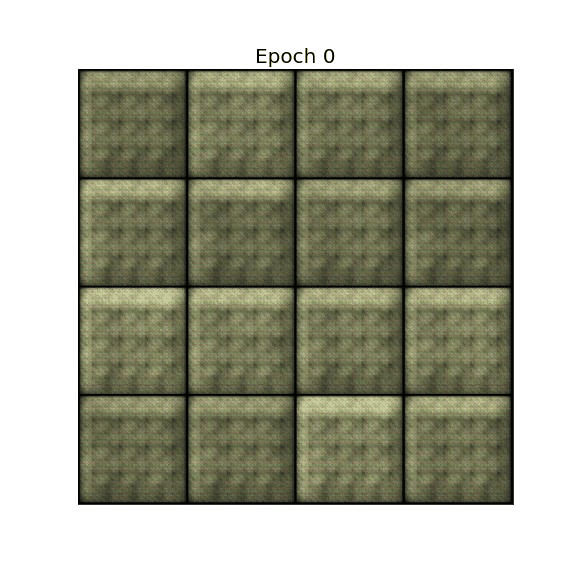

In [2]:
plot_loss(dcgan_128.loss_generator, dcgan_128.loss_discriminator)

Выведение на экран результата обучения:

In [ ]:
dcgan_128.print_generation_gif()

Выведение сравнения настоящих и сгенерированных фотографий:

In [ ]:
plot_comparison_real_fake(train_dataloader, dcgan_128.images, device)

>Модель справилась с поставленной задачей.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

На основании датасета с домашними животными был проведён эксперимент по построению генеративно-состязательной сети DCGAN (обучение проведено на датасете с размером изображений 128х128). Однако производительность компьютера не позволила произвести его до конца - было пройдено только 26 эпох обучения. Тем не менее, с учётом имеющихся результатов можно предположить, что сеть вполне способна продемонстрировать более чёткий результат в рамках поставленной задачи. 

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>